In [1]:
import os
import sys
import pickle
import random
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt

random.seed(42)

import pandas as pd

# Load in the protein-to-gene conversion table
unimap = pd.read_csv("../data/databases/uniprot_to_gene.txt", 
                     sep = "\t", usecols=['UniProt','GeneSymbol'])

n_perm = 10000

In [2]:
def get_interactome(int_type):
    gene_file = "../intermediate/interactome_lists/{}_genes.txt".format(int_type)
    gene_list = []
    
    with open(gene_file) as f:
        for line in f:
            gene_list.append(line.strip())
            
    return gene_list

In [3]:
def get_dnv_dicts(mut_type, unknown=False):
    
    mut_str_dict = {'LoF':['non','frameshift','startloss','stoploss','loss of function'],
                    'misD':['misD'], 'splice_':['splice'], 'mis_':['mis','misD'],
                   'allmuts':['non','frameshift','startloss','stoploss','misD','splice','mis',
                              'loss of function'],
                   'allmis':['misD','mis']}
    
    CHD_proband_dict = defaultdict(list)
    ASD_sibling_dict = defaultdict(list)
    
    if mut_type == "syn":
        case_file = "../data/variants/DNV_cases_syn.csv"
        ctrl_file = "../data/variants/DNV_ctrls_syn.csv"
        
        with open(case_file) as f:
            first_line = f.readline()
            gene_idx = first_line.split(',').index('Gene')
            for line in f:
                line_array = line.split(',')
                
                if unknown==True:
                    if line_array[gene_idx] in known_genes:
                        continue

                CHD_proband_dict[line_array[0]].append(line_array[gene_idx])

        with open(ctrl_file) as f:
            first_line = f.readline()
            gene_idx = first_line.split(',').index('Gene')
            for line in f:
                line_array = line.split(',')
                
                if unknown==True:
                    if line_array[gene_idx] in known_genes:
                        continue

                ASD_sibling_dict[line_array[0]].append(line_array[gene_idx])
                    
    else:
        case_file = "../data/variants/DNV_cases_nonsyn.csv"
        ctrl_file = "../data/variants/DNV_ctrls_nonsyn.csv"

        with open(case_file) as f:
            first_line = f.readline()
            gene_idx = first_line.split(',').index('Gene')
            class_idx = first_line.split(',').index('Variant Class')
            
            for line in f:
                line_array = line.split(',')
                
                if unknown==True:
                    if line_array[gene_idx] in known_genes:
                        continue

                if line_array[class_idx] in mut_str_dict[mut_type]:
                    CHD_proband_dict[line_array[0]].append(line_array[gene_idx])

        with open(ctrl_file) as f:
            first_line = f.readline()
            gene_idx = first_line.split(',').index('Gene')
            class_idx = first_line.split(',').index('Variant Class')
            
            for line in f:
                line_array = line.split(',')
                
                if unknown==True:
                    if line_array[gene_idx] in known_genes:
                        continue

                if line_array[class_idx] in mut_str_dict[mut_type]:
                    ASD_sibling_dict[line_array[0]].append(line_array[gene_idx])

    return CHD_proband_dict, ASD_sibling_dict

# Add empty placeholders for individuals with no called de novos in either category
def add_placeholders(variant_dict, expected_n, prefix=""):
    
    if len(variant_dict) < expected_n:
        n_placeholders = expected_n - len(variant_dict)
        ids = range(0,n_placeholders)
        for i in ids:
            variant_dict["{}_placeholder{}".format(prefix,i)] = []

    return(variant_dict)

In [4]:
def get_lof_dicts(mut_type = "lof", unknown_only = False):
    
    print(mut_type)

    case_file = "../data/variants/LoF_cases.csv"
    ctrl_file = "../data/variants/LoF_ctrls.csv"

    CHD_proband_dict = get_id_dict(case_file, unknown_only = unknown_only)
    ASD_sibling_dict = get_id_dict(ctrl_file, unknown_only = unknown_only)
 
    return CHD_proband_dict, ASD_sibling_dict

def get_id_dict(filename, unknown_only = False):
    
    id_dict = defaultdict(list)
    with open(filename) as f:
        
        first_line = f.readline().strip().split(',')
        gene_idx = next(x for x,val in enumerate(first_line) if val == "Gene")
        class_idx = next(x for x,val in enumerate(first_line) if val in ['Variant.Class','Variant_Class',
                                                                         'Variant Class','ExonicFunc.refGene'])
        next(f)
        
        for line in f:
            line_array = line.split(',')
            
            # Ignore if it's a known gene and we're ignoring them
            if unknown_only==True:
                if line_array[gene_idx] in known_genes:
                    continue
            # Only save to dictionary if it's in the type of variants we're analyzing
            id_dict[line_array[0]].append(line_array[gene_idx])
                
    return id_dict

In [5]:
# Functions to calculate odds ratio
def get_OR(case_dict, ctrl_dict, gene_list, printcounts=False):
    
    case_ct, case_non_ct = get_ctable(case_dict, gene_list)
    ctrl_ct, ctrl_non_ct = get_ctable(ctrl_dict, gene_list)
                
    # Add pseudocount if any values are equal to zero
    if 0 in [case_ct, case_non_ct, ctrl_ct, ctrl_non_ct]:
        case_ct+=0.5; case_non_ct+=0.5; ctrl_ct+=0.5; ctrl_non_ct+=0.5;
        
    # Calculate odds ratio
    odds = (case_ct * ctrl_non_ct) / (ctrl_ct * case_non_ct)
        
    # Print contingency table, if it's the true odds ratio
    if printcounts == True:
        print("Case interactome muts: {}".format(case_ct))
        print("Case non-interactome muts: {}".format(case_non_ct))
        print("Ctrl interactome muts: {}".format(ctrl_ct))
        print("Ctrl non-interactome muts: {}".format(ctrl_non_ct))
        print("Odds ratio: {}".format(odds))
        
    return(odds)

# Function to iterate through dictionary, returning contingency table
def get_ctable(dictionary, gene_list):
    yes_ct = 0; no_ct = 0
    
    # Create contingency table - get yes and no values
    for indi in dictionary:
        
        for genes in dictionary[indi]:

            if (genes in gene_list):
                yes_ct += 1
            else:
                no_ct += 1
                
    return(yes_ct, no_ct)

In [6]:
# Random shuffle using numpy
def np_random_shuffle(a):
    
    keys = list(a.keys())
    np.random.shuffle(keys)
    b = dict(zip(keys, a.values()))
    return(b)

# Scramble the IDs from the case and control dictionaries
def scramble_ids(case_dict, ctrl_dict):
    
    combined_dict = {**case_dict, **ctrl_dict} 
    scrambled_dict = np_random_shuffle(combined_dict)
    
    case_ids = []
    ctrl_ids = []
    for key in combined_dict:
        if key.startswith("1-") or key.startswith("GT"):
            case_ids.append(key)
        else:
            ctrl_ids.append(key)
    
    scram_case = {k: scrambled_dict[k] for k in case_ids}
    scram_ctrl = {k: scrambled_dict[k] for k in ctrl_ids}
    
    return(scram_case, scram_ctrl)

    
# Function to return n permuted odds ratios
def permute_status(case_dict, ctrl_dict, gene_list, n_perm):
    
    perm_list = []
    for i in range(0,n_perm):
        scram_case, scram_ctrl = scramble_ids(case_dict, ctrl_dict)
        perm_list.append(get_OR(scram_case, scram_ctrl, interactome))
        
    return(perm_list)
    

In [7]:
# Function to calculate p-value from list of permutation results
def perm_res(perm_list, oddsratio):
    
    nGreater = len([num for num in perm_list if num > oddsratio])
    pval = nGreater/len(perm_list)
    minp = 1/len(perm_list)
    
    if nGreater == 0:
        pval = "<{}".format(minp)
        
    return(pval)

# save out figure and text file
def permutation_visualization(perm_list, OR, mut_type):
    
    pval = perm_res(perm_list, OR)
    print("P-value: ", pval)
    mut_str = mut_type.split("_")[0]
    
    # Plot - original
    plt.clf()
    plt.hist(perm_list)
    plt.suptitle('{} mutations'.format(mut_str), fontsize=18)
    plt.figtext(0.99, 0.01, 'p-value = {}'.format(pval), horizontalalignment='right')
    plt.xlabel('Odds Ratios', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    ax = plt.axvline(OR, color='red', linewidth=2)
    plt.show()

In [9]:
# Known CHD-associated genes
fname = "../data/databases/known_CHD_genes.txt"
known_genes = []
with open(fname) as f:
    for line in f:
        known_genes.append(line.strip())

In [10]:
# Dataset-wide synonymous correction factor
def get_synonymous_correction(known_status, list_of_interactomes):

    joint_genes = []
    mut_type = "syn"

    for interactome in list_of_interactomes:
        int_genes = get_interactome(interactome)
        joint_genes = joint_genes + int_genes

    if known_status == "allGenes":
        probands, siblings = get_dnv_dicts(mut_type)
    else:
        probands, siblings = get_dnv_dicts(mut_type, unknown=True)

    # Account for individuals without DNMs
    probands = add_placeholders(probands, 3509)
    siblings = add_placeholders(siblings, 1789)

    syn_or = get_OR(probands, siblings, joint_genes, printcounts=True)
    synonymous_correction = 1/syn_or
        
    return synonymous_correction

list_of_interactomes = ["GATA4","TBX5","HEK-GATA4","HEK-TBX5","HCC-GATA4","MOUSE-TBX5","DB-GATA4","DB-TBX5"]
allgenes_correction = get_synonymous_correction('allGenes', list_of_interactomes)
unknowngenes_correction = get_synonymous_correction('unknownGenes', list_of_interactomes)

# For your first (GATA4) example, there are 0+830=830 synonymous variants in cases and 3+481=484 in controls. 
# The ratio is 830/484 = 1.71. 
# If you divide the case non-synonymous counts by 1.71, you get 
#20->12
#2520->1474
# which are the expected counts if there were similar numbers of case and control variants. 
# This puts the non-synonymous OR at 1.09. 

# Alternatively, you could multiple the control counts by 484/830. 

# I don’t think this addresses low counts skewing the ORs though. So not sure if it is helpful. Applying 
# the 1.71 multiplier to the synonymous case counts doesn’t put its OR = 1, though it is better 
# (correct syn OR = 0.86). 

Case interactome muts: 22
Case non-interactome muts: 808
Ctrl interactome muts: 18
Ctrl non-interactome muts: 466
Odds ratio: 0.7048954895489549
Case interactome muts: 22
Case non-interactome muts: 788
Ctrl interactome muts: 16
Ctrl non-interactome muts: 460
Odds ratio: 0.8026649746192893


In [15]:
int_type = "DB-GATA4"
known_status = 'allGenes'
interactome = get_interactome(int_type)
mut_type = 'allmuts'

probands, siblings = get_dnv_dicts(mut_type)
probands = add_placeholders(probands, 3509)#, 'case')
siblings = add_placeholders(siblings, 1789)#, 'ctrl')
original_OR = get_OR(probands, siblings, interactome, printcounts=True)

Case interactome muts: 2.5
Case non-interactome muts: 2538.5
Ctrl interactome muts: 0.5
Ctrl non-interactome muts: 1346.5
Odds ratio: 2.6521567855032497


201
syn
Case interactome muts: 7
Case non-interactome muts: 823
Ctrl interactome muts: 10
Ctrl non-interactome muts: 474
Odds ratio: 0.4031591737545565
Normalized Odds Ratio:  1.0
Joint-normalized OR:  0.5532239773187525
allmuts
Case interactome muts: 63
Case non-interactome muts: 2477
Ctrl interactome muts: 15
Ctrl non-interactome muts: 1331
Odds ratio: 2.256842955187727
Normalized Odds Ratio:  5.597895576008135
Joint-normalized OR:  3.0968900551742697
P-value:  <0.0001


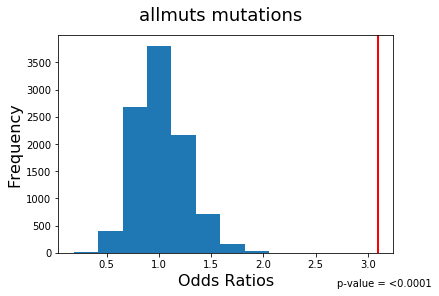

lof
Case interactome muts: 77
Case non-interactome muts: 13757
Ctrl interactome muts: 70
Ctrl non-interactome muts: 13199
Odds ratio: 1.0553827142545613
Normalized Odds Ratio:  2.6177817173945264
Joint-normalized OR:  1.4482196134493146
P-value:  0.3676


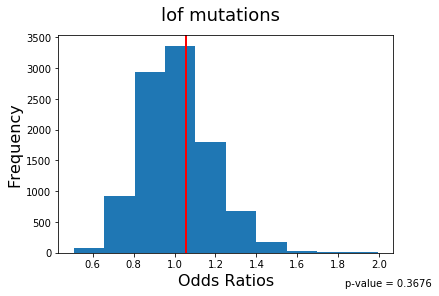

201
syn
Case interactome muts: 7
Case non-interactome muts: 803
Ctrl interactome muts: 9
Ctrl non-interactome muts: 467
Odds ratio: 0.45233153452331537
Normalized Odds Ratio:  0.9999999999999999
Joint-normalized OR:  0.5732446339289037
allmuts
Case interactome muts: 36
Case non-interactome muts: 2341
Ctrl interactome muts: 15
Ctrl non-interactome muts: 1302
Odds ratio: 1.3348141819735155
Normalized Odds Ratio:  2.9509642377248686
Joint-normalized OR:  1.6916244141918786
P-value:  0.0313


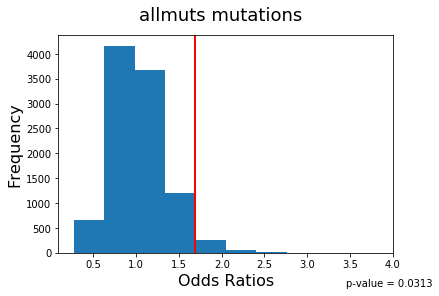

lof
Case interactome muts: 72
Case non-interactome muts: 13500
Ctrl interactome muts: 65
Ctrl non-interactome muts: 12992
Odds ratio: 1.0660102564102565
Normalized Odds Ratio:  2.356701169494317
Joint-normalized OR:  1.350966299186589
P-value:  0.3555


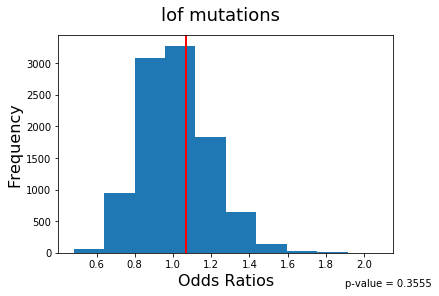

61
syn
Case interactome muts: 4
Case non-interactome muts: 826
Ctrl interactome muts: 3
Ctrl non-interactome muts: 481
Odds ratio: 0.7764326069410815
Normalized Odds Ratio:  1.0
Joint-normalized OR:  1.065438077302484
allmuts
Case interactome muts: 19
Case non-interactome muts: 2521
Ctrl interactome muts: 1
Ctrl non-interactome muts: 1345
Odds ratio: 10.136850456168187
Normalized Odds Ratio:  13.055673300615783
Joint-normalized OR:  13.910011459297456
P-value:  <0.0001


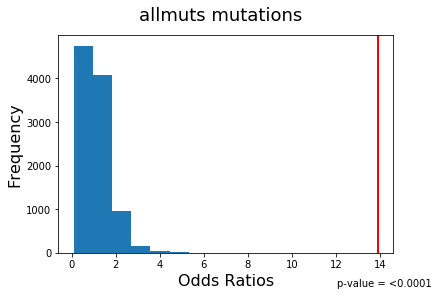

lof
Case interactome muts: 25
Case non-interactome muts: 13809
Ctrl interactome muts: 27
Ctrl non-interactome muts: 13242
Odds ratio: 0.887907242458622
Normalized Odds Ratio:  1.1435728413786204
Joint-normalized OR:  1.2184060493737756
P-value:  0.6649


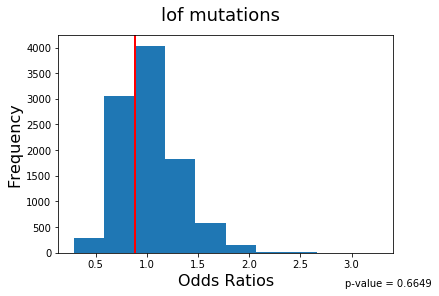

61
syn
Case interactome muts: 4
Case non-interactome muts: 806
Ctrl interactome muts: 3
Ctrl non-interactome muts: 473
Odds ratio: 0.782464846980976
Normalized Odds Ratio:  1.0
Joint-normalized OR:  0.991626142631285
allmuts
Case interactome muts: 11
Case non-interactome muts: 2366
Ctrl interactome muts: 1
Ctrl non-interactome muts: 1316
Odds ratio: 6.118343195266272
Normalized Odds Ratio:  7.819320214669053
Joint-normalized OR:  7.753842342471104
P-value:  0.0029


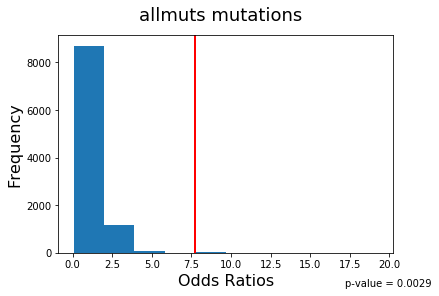

lof
Case interactome muts: 24
Case non-interactome muts: 13548
Ctrl interactome muts: 27
Ctrl non-interactome muts: 13030
Odds ratio: 0.8549027326706689
Normalized Odds Ratio:  1.0925765367852418
Joint-normalized OR:  1.0834274567017976
P-value:  0.7215


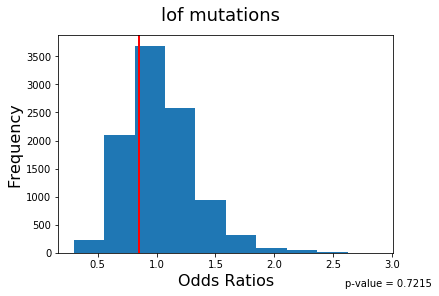

142
syn
Case interactome muts: 6
Case non-interactome muts: 824
Ctrl interactome muts: 4
Ctrl non-interactome muts: 480
Odds ratio: 0.8737864077669902
Normalized Odds Ratio:  1.0
Joint-normalized OR:  1.1990291262135921
allmuts
Case interactome muts: 36
Case non-interactome muts: 2504
Ctrl interactome muts: 11
Ctrl non-interactome muts: 1335
Odds ratio: 1.744844612256753
Normalized Odds Ratio:  1.996877722916062
Joint-normalized OR:  2.394314551263433
P-value:  0.0019


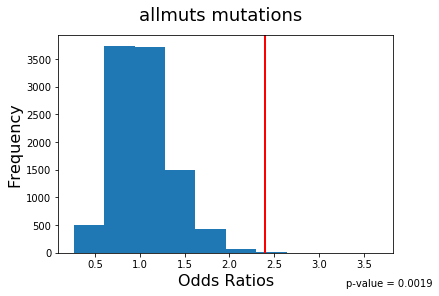

lof
Case interactome muts: 50
Case non-interactome muts: 13784
Ctrl interactome muts: 44
Ctrl non-interactome muts: 13225
Odds ratio: 1.0902792433915476
Normalized Odds Ratio:  1.247764022992549
Joint-normalized OR:  1.4961054062095125
P-value:  0.3424


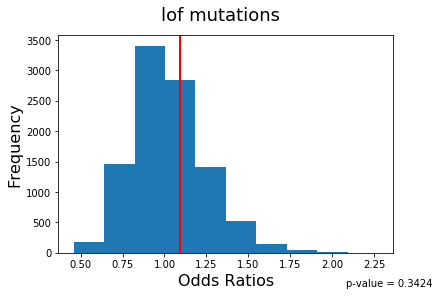

142
syn
Case interactome muts: 6
Case non-interactome muts: 804
Ctrl interactome muts: 4
Ctrl non-interactome muts: 472
Odds ratio: 0.8805970149253731
Normalized Odds Ratio:  1.0
Joint-normalized OR:  1.1159900978200783
allmuts
Case interactome muts: 29
Case non-interactome muts: 2348
Ctrl interactome muts: 11
Ctrl non-interactome muts: 1306
Odds ratio: 1.4663930617934025
Normalized Odds Ratio:  1.6652260193247115
Joint-normalized OR:  1.858375748198724
P-value:  0.0207


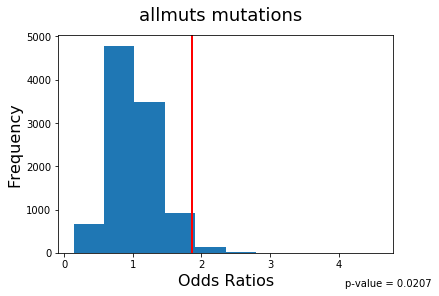

lof
Case interactome muts: 43
Case non-interactome muts: 13529
Ctrl interactome muts: 35
Ctrl non-interactome muts: 13022
Odds ratio: 1.182530648448307
Normalized Odds Ratio:  1.3428737872209588
Joint-normalized OR:  1.4986338491607365
P-value:  0.2301


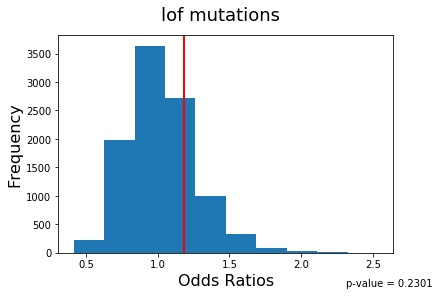

88
syn
Case interactome muts: 3
Case non-interactome muts: 827
Ctrl interactome muts: 1
Ctrl non-interactome muts: 483
Odds ratio: 1.7521160822249093
Normalized Odds Ratio:  1.0
Joint-normalized OR:  2.404292623941959
allmuts
Case interactome muts: 27
Case non-interactome muts: 2513
Ctrl interactome muts: 5
Ctrl non-interactome muts: 1341
Odds ratio: 2.881575805809789
Normalized Odds Ratio:  1.6446260810246347
Joint-normalized OR:  3.9541623557500993
P-value:  <0.0001


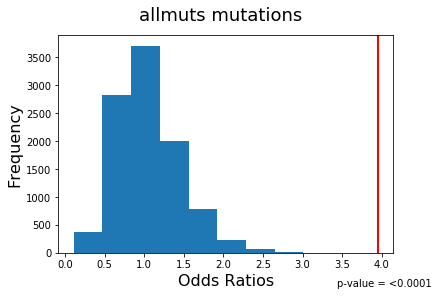

lof
Case interactome muts: 17
Case non-interactome muts: 13817
Ctrl interactome muts: 15
Ctrl non-interactome muts: 13254
Odds ratio: 1.0871535065499023
Normalized Odds Ratio:  0.6204802966989436
Joint-normalized OR:  1.491816200654588
P-value:  0.3748


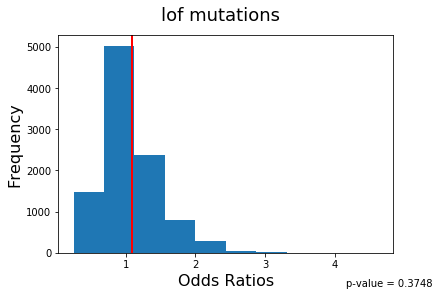

88
syn
Case interactome muts: 3
Case non-interactome muts: 807
Ctrl interactome muts: 1
Ctrl non-interactome muts: 475
Odds ratio: 1.7657992565055762
Normalized Odds Ratio:  1.0
Joint-normalized OR:  2.2378164490658428
allmuts
Case interactome muts: 21
Case non-interactome muts: 2356
Ctrl interactome muts: 5
Ctrl non-interactome muts: 1312
Odds ratio: 2.3388794567062816
Normalized Odds Ratio:  1.3245443660083995
Joint-normalized OR:  2.9640871697710844
P-value:  0.0028


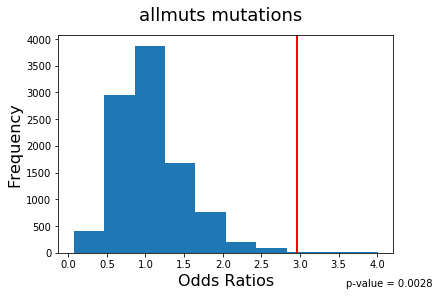

lof
Case interactome muts: 16
Case non-interactome muts: 13556
Ctrl interactome muts: 15
Ctrl non-interactome muts: 13042
Odds ratio: 1.026222091078981
Normalized Odds Ratio:  0.5811657736847282
Joint-normalized OR:  1.3005423279857615
P-value:  0.4238


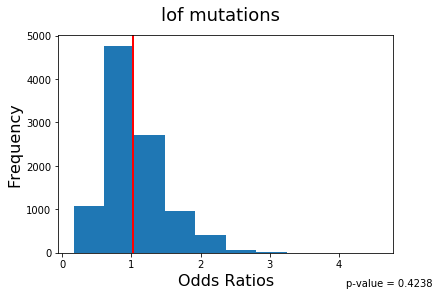

76
syn
Case interactome muts: 0.5
Case non-interactome muts: 830.5
Ctrl interactome muts: 3.5
Ctrl non-interactome muts: 481.5
Odds ratio: 0.08282446030790401
Normalized Odds Ratio:  1.0
Joint-normalized OR:  0.11365356497806828
allmuts
Case interactome muts: 20
Case non-interactome muts: 2520
Ctrl interactome muts: 10
Ctrl non-interactome muts: 1336
Odds ratio: 1.0603174603174603
Normalized Odds Ratio:  12.80198453905619
Joint-normalized OR:  1.4549911816578482
P-value:  0.1473


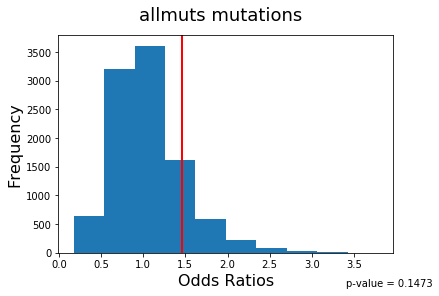

lof
Case interactome muts: 35
Case non-interactome muts: 13799
Ctrl interactome muts: 43
Ctrl non-interactome muts: 13226
Odds ratio: 0.7801542747452208
Normalized Odds Ratio:  9.419370459462806
Joint-normalized OR:  1.070545032567053
P-value:  0.8654


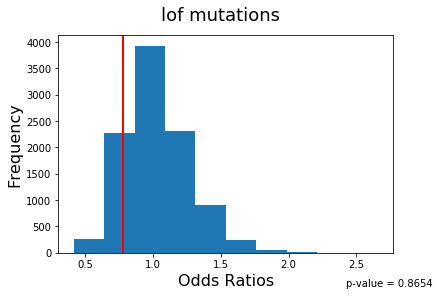

76
syn
Case interactome muts: 0.5
Case non-interactome muts: 810.5
Ctrl interactome muts: 2.5
Ctrl non-interactome muts: 474.5
Odds ratio: 0.11708821714990747
Normalized Odds Ratio:  1.0
Joint-normalized OR:  0.14838716086469753
allmuts
Case interactome muts: 14
Case non-interactome muts: 2363
Ctrl interactome muts: 10
Ctrl non-interactome muts: 1307
Odds ratio: 0.7743546339399069
Normalized Odds Ratio:  6.613429197136928
Joint-normalized OR:  0.9813479821428448
P-value:  0.5386


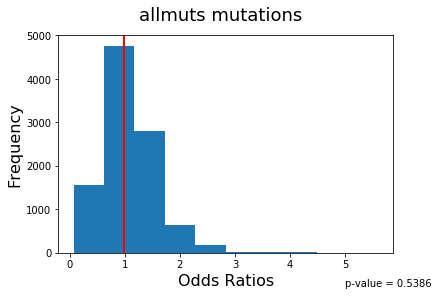

lof
Case interactome muts: 33
Case non-interactome muts: 13539
Ctrl interactome muts: 41
Ctrl non-interactome muts: 13016
Odds ratio: 0.7737862975793507
Normalized Odds Ratio:  6.60857528122301
Joint-normalized OR:  0.9806277233413027
P-value:  0.8578


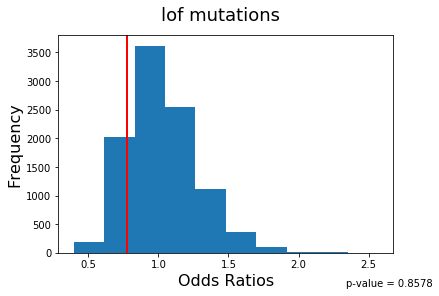

58
syn
Case interactome muts: 7
Case non-interactome muts: 823
Ctrl interactome muts: 1
Ctrl non-interactome muts: 483
Odds ratio: 4.108140947752126
Normalized Odds Ratio:  1.0
Joint-normalized OR:  5.637282300526529
allmuts
Case interactome muts: 16
Case non-interactome muts: 2524
Ctrl interactome muts: 4
Ctrl non-interactome muts: 1342
Odds ratio: 2.126782884310618
Normalized Odds Ratio:  0.5176995899993015
Joint-normalized OR:  2.9184187356929034
P-value:  0.0118


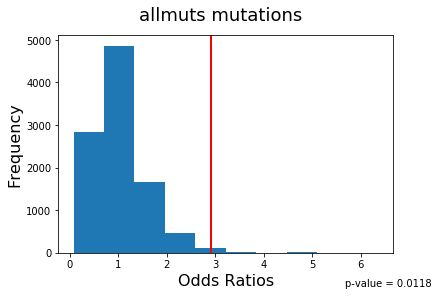

lof
Case interactome muts: 29
Case non-interactome muts: 13805
Ctrl interactome muts: 13
Ctrl non-interactome muts: 13256
Odds ratio: 2.142055554007745
Normalized Odds Ratio:  0.5214172496150176
Joint-normalized OR:  2.939376232443961
P-value:  0.0094


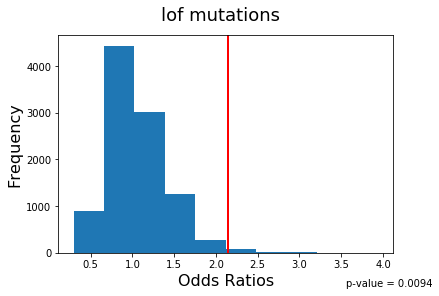

58
syn
Case interactome muts: 7
Case non-interactome muts: 803
Ctrl interactome muts: 1
Ctrl non-interactome muts: 475
Odds ratio: 4.140722291407223
Normalized Odds Ratio:  1.0
Joint-normalized OR:  5.247582034359878
allmuts
Case interactome muts: 10
Case non-interactome muts: 2367
Ctrl interactome muts: 4
Ctrl non-interactome muts: 1313
Odds ratio: 1.3867765103506549
Normalized Odds Ratio:  0.33491174069521074
Joint-normalized OR:  1.7574768335683821
P-value:  0.1209


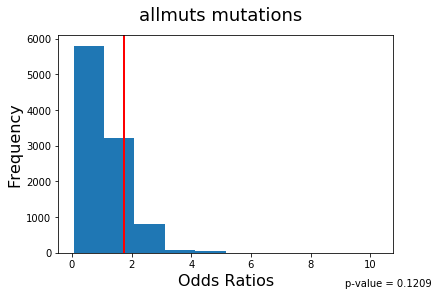

lof
Case interactome muts: 28
Case non-interactome muts: 13544
Ctrl interactome muts: 13
Ctrl non-interactome muts: 13044
Odds ratio: 2.074333227316098
Normalized Odds Ratio:  0.5009592726420531
Joint-normalized OR:  2.6288248790624302
P-value:  0.0122


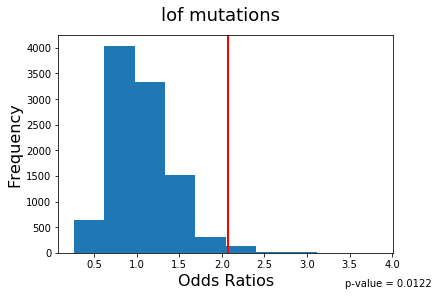

24
syn
Case interactome muts: 2
Case non-interactome muts: 828
Ctrl interactome muts: 1
Ctrl non-interactome muts: 483
Odds ratio: 1.1666666666666667
Normalized Odds Ratio:  1.0
Joint-normalized OR:  1.600925925925926
allmuts
Case interactome muts: 7
Case non-interactome muts: 2533
Ctrl interactome muts: 1
Ctrl non-interactome muts: 1345
Odds ratio: 3.7169364390051323
Normalized Odds Ratio:  3.185945519147256
Joint-normalized OR:  5.100462780190376
P-value:  0.0078


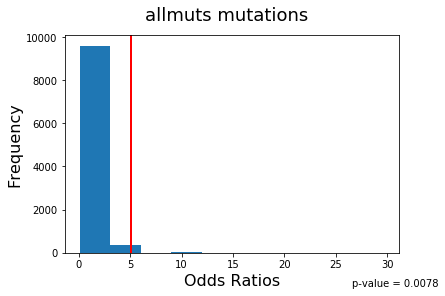

lof
Case interactome muts: 9
Case non-interactome muts: 13825
Ctrl interactome muts: 6
Ctrl non-interactome muts: 13263
Odds ratio: 1.4390235081374323
Normalized Odds Ratio:  1.2334487212606562
Joint-normalized OR:  1.9746600361663655
P-value:  0.2556


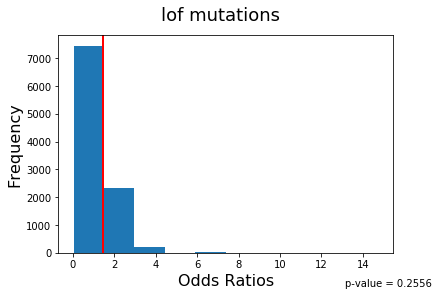

24
syn
Case interactome muts: 1
Case non-interactome muts: 809
Ctrl interactome muts: 1
Ctrl non-interactome muts: 475
Odds ratio: 0.5871446229913473
Normalized Odds Ratio:  1.0
Joint-normalized OR:  0.7440947154495817
allmuts
Case interactome muts: 4
Case non-interactome muts: 2373
Ctrl interactome muts: 1
Ctrl non-interactome muts: 1316
Odds ratio: 2.218289085545723
Normalized Odds Ratio:  3.7780965688557684
Joint-normalized OR:  2.8112616913437742
P-value:  0.0674


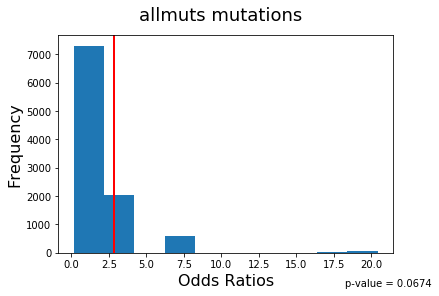

lof
Case interactome muts: 2
Case non-interactome muts: 13570
Ctrl interactome muts: 3
Ctrl non-interactome muts: 13054
Odds ratio: 0.6413166298206828
Normalized Odds Ratio:  1.0922634811051208
Joint-normalized OR:  0.8127474841688845
P-value:  0.7939


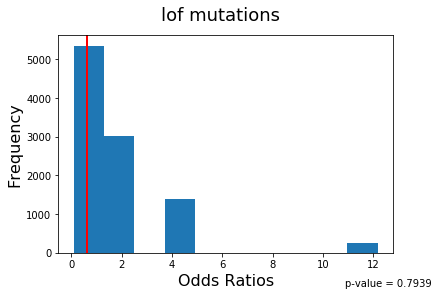

6
syn
Case interactome muts: 0.5
Case non-interactome muts: 830.5
Ctrl interactome muts: 0.5
Ctrl non-interactome muts: 484.5
Odds ratio: 0.5833835039133053
Normalized Odds Ratio:  1.0
Joint-normalized OR:  0.8005318081477023
allmuts
Case interactome muts: 4.5
Case non-interactome muts: 2536.5
Ctrl interactome muts: 0.5
Ctrl non-interactome muts: 1346.5
Odds ratio: 4.777646363098758
Normalized Odds Ratio:  8.189546552226044
Joint-normalized OR:  6.555992509363295
P-value:  0.023


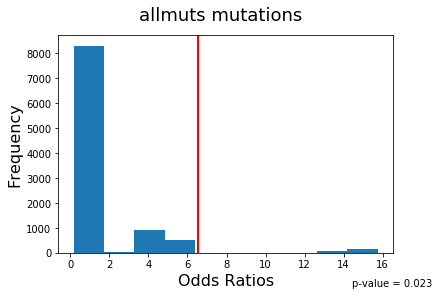

lof
Case interactome muts: 4
Case non-interactome muts: 13830
Ctrl interactome muts: 2
Ctrl non-interactome muts: 13267
Odds ratio: 1.918582791033984
Normalized Odds Ratio:  3.2887162186867362
Joint-normalized OR:  2.632721941029967
P-value:  0.3096


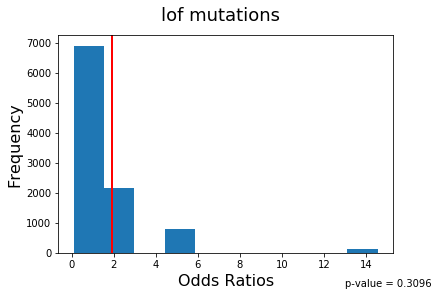

6
syn
Case interactome muts: 0.5
Case non-interactome muts: 810.5
Ctrl interactome muts: 0.5
Ctrl non-interactome muts: 476.5
Odds ratio: 0.5879086983343615
Normalized Odds Ratio:  1.0
Joint-normalized OR:  0.7450630363754307
allmuts
Case interactome muts: 1.5
Case non-interactome muts: 2376.5
Ctrl interactome muts: 0.5
Ctrl non-interactome muts: 1317.5
Odds ratio: 1.6631601094045865
Normalized Odds Ratio:  2.828942851358693
Joint-normalized OR:  2.1077407505658767
P-value:  0.3685


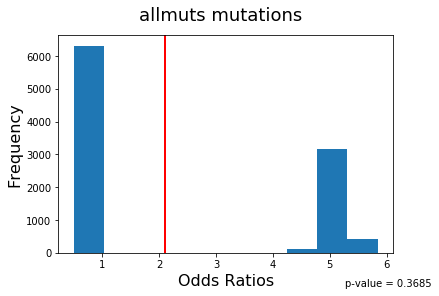

lof
Case interactome muts: 0.5
Case non-interactome muts: 13572.5
Ctrl interactome muts: 1.5
Ctrl non-interactome muts: 13056.5
Odds ratio: 0.32066064959783874
Normalized Odds Ratio:  0.5454259317923363
Joint-normalized OR:  0.4063767008590967
P-value:  1.0


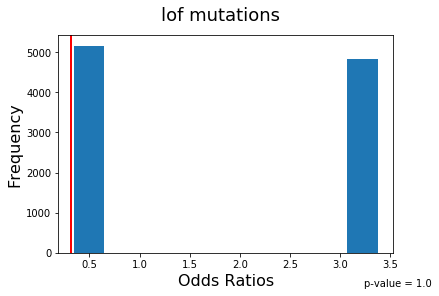

In [20]:
results_list = []

for int_type in list_of_interactomes:
    
    for known_status in ["allGenes","unknownGenes"]:
        
        print("{} interactome, {}".format(int_type, known_status))

        interactome = get_interactome(int_type)
        print(len(interactome))

        ### Synonymous DNVs
        mut_type = "syn"
        print(mut_type)

        # Reduce dictionaries to desired MAF cutoff
        if known_status == "allGenes":
            probands, siblings = get_dnv_dicts(mut_type)
            joint_correction = allgenes_correction
        else:
            probands, siblings = get_dnv_dicts(mut_type, True)
            joint_correction = unknowngenes_correction

        # Account for individuals without DNMs
        probands = add_placeholders(probands, 3509)#, 'case')
        siblings = add_placeholders(siblings, 1789)#, 'ctrl')

        # Get true odds ratio
        original_OR = get_OR(probands, siblings, interactome, printcounts=True)

        # Find interactome-specific correction
        correction_val = 1/original_OR

        # Run permutations, correct values with or_correction
        perm_list = permute_status(probands,siblings,interactome,n_perm)
        
        int_normalized_OR = original_OR * correction_val
        joint_normalized_OR = original_OR * joint_correction
        print("Normalized Odds Ratio: ", int_normalized_OR)
        print("Joint-normalized OR: ", joint_normalized_OR)

        pval = perm_res(perm_list, original_OR)
        int_normalized_pval = perm_res(perm_list, int_normalized_OR)
        joint_normalized_pval = perm_res(perm_list, joint_normalized_OR)
        
        keystr = "{}_syn_{}_denovo".format(int_type, known_status)
        results_list.append([keystr, original_OR, pval, 
                             int_normalized_OR, int_normalized_pval,
                             joint_normalized_OR, joint_normalized_pval])


        ### Non-synonymous DNVs
        mut_type = 'allmuts'
        print(mut_type)

        # Reduce dictionaries to desired MAF cutoff
        if known_status == "allGenes":
            probands, siblings = get_dnv_dicts(mut_type)
        else:
            probands, siblings = get_dnv_dicts(mut_type, True)

        # Get true odds ratio
        probands = add_placeholders(probands, 3509)#, 'case')
        siblings = add_placeholders(siblings, 1789)#, 'ctrl')
        
        # Get true odds ratio
        original_OR = get_OR(probands, siblings, interactome, printcounts=True)

        # Run permutations, correct values with or_correction
        perm_list = permute_status(probands,siblings,interactome,n_perm)
        
        int_normalized_OR = original_OR * correction_val
        joint_normalized_OR = original_OR * joint_correction
        print("Normalized Odds Ratio: ", int_normalized_OR)
        print("Joint-normalized OR: ", joint_normalized_OR)

        pval = perm_res(perm_list, original_OR)
        int_normalized_pval = perm_res(perm_list, int_normalized_OR)
        joint_normalized_pval = perm_res(perm_list, joint_normalized_OR)

        permutation_visualization(perm_list, joint_normalized_OR, mut_type)
        keystr = "{}_nonsyn_{}_denovo".format(int_type, known_status)
        results_list.append([keystr, original_OR, pval, 
                             int_normalized_OR, int_normalized_pval,
                             joint_normalized_OR, joint_normalized_pval])
        
        
        ### LOF 
        mut_type = "lof"
        if known_status == "allGenes":
            probands, siblings = get_lof_dicts(mut_type)
        else:
            probands, siblings = get_lof_dicts(mut_type, True)

        # Get true odds ratio
        original_OR = get_OR(probands, siblings, interactome, printcounts=True)

        # Get 10000 permutations and read out results
        perm_list = permute_status(probands,siblings,interactome,n_perm)
        
        int_normalized_OR = original_OR * correction_val
        joint_normalized_OR = original_OR * joint_correction
        print("Normalized Odds Ratio: ", int_normalized_OR)
        print("Joint-normalized OR: ", joint_normalized_OR)
        
        pval = perm_res(perm_list, original_OR)
        int_normalized_pval = perm_res(perm_list, int_normalized_OR)
        joint_normalized_pval = perm_res(perm_list, joint_normalized_OR)

        keystr = "{}_inh-lof_{}_inherited".format(int_type, known_status)
        results_list.append([keystr, original_OR, pval, 
                             int_normalized_OR, int_normalized_pval,
                             joint_normalized_OR, joint_normalized_pval])

        permutation_visualization(perm_list, original_OR, mut_type)

        

In [21]:
results_df = pd.DataFrame(results_list, 
                       columns=['test', 'original_OR', 'pval', 
                             'int_normalized_OR', 'int_normalized_pval',
                             'joint_normalized_OR', 'joint_normalized_pval'])
results_df.to_csv('../intermediate/temp_permutation_results_older-interactome.csv', index=False)

205
lof
Case interactome muts: 74
Case non-interactome muts: 12257
Ctrl interactome muts: 75
Ctrl non-interactome muts: 13194
Odds ratio: 1.0620934975932121
Odds Ratio:  1.0620934975932121
P-value:  0.3601
P-value:  0.3601


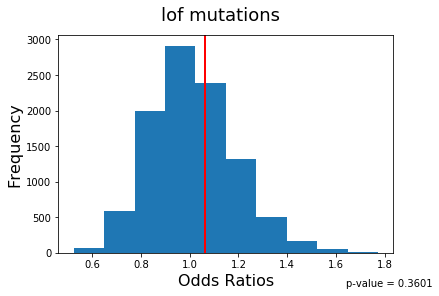

lof
Case interactome muts: 69
Case non-interactome muts: 12020
Ctrl interactome muts: 70
Ctrl non-interactome muts: 12987
Odds ratio: 1.0650142619443783
Odds Ratio:  1.0650142619443783
P-value:  0.3471
P-value:  0.3471


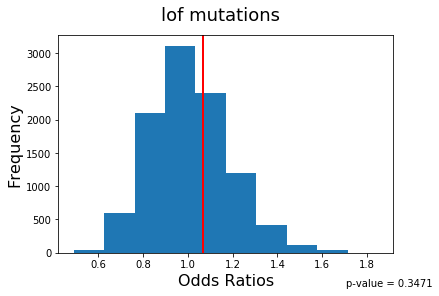

64
lof
Case interactome muts: 24
Case non-interactome muts: 12307
Ctrl interactome muts: 28
Ctrl non-interactome muts: 13241
Odds ratio: 0.9221929447817154
Odds Ratio:  0.9221929447817154
P-value:  0.5871
P-value:  0.5871


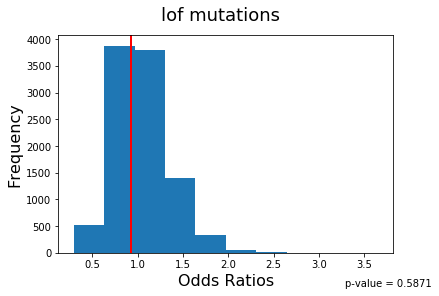

lof
Case interactome muts: 23
Case non-interactome muts: 12066
Ctrl interactome muts: 27
Ctrl non-interactome muts: 13030
Odds ratio: 0.9199096328219484
Odds Ratio:  0.9199096328219484
P-value:  0.6016
P-value:  0.6016


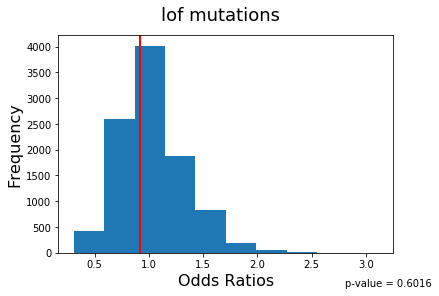

259
lof
Case interactome muts: 89
Case non-interactome muts: 12242
Ctrl interactome muts: 98
Ctrl non-interactome muts: 13171
Odds ratio: 0.9770804090301372
Odds Ratio:  0.9770804090301372


KeyboardInterrupt: 

In [18]:
for int_type in ["GATA4","TBX5","GATA4-TBX5","HEK-GATA4","HEK-TBX5","HEKGATA4-HEKTBX5"]:
    
    interactome = get_interactome(int_type)
    print(len(interactome))
    
    for known_status in ["allGenes","unknownGenes"]:
        
        ### LOF 
        mut_type = "lof"
        if known_status == "allGenes":
            probands, siblings = get_lof_dicts(mut_type)
        else:
            probands, siblings = get_lof_dicts(mut_type, True)
            
        # Get true odds ratio
        OR = get_OR(probands, siblings, interactome, printcounts=True)
        print("Odds Ratio: ", OR)
        
        # Get 1000 permutations and read out results
        perm_list = permute_status(probands,siblings,interactome,n_perm)

        pval = perm_res(perm_list, OR)
        print("P-value: ", pval)
        keystr = "inh-{}_nonsyn_{}_original_denovo".format(int_type, known_status)
        results_list.append([keystr, OR, pval])
        
        permutation_visualization(perm_list, OR, mut_type)
        

In [ ]:
combined = pd.DataFrame(results_list)
combined.columns = ['permutation','OR','PVAL']
combined[['Interactome','MutationType','GeneList','ORType','Inheritance']] = combined['permutation'].str.split("_",expand=True) 
combined.head()


In [ ]:
# Separate by distinct tests

known_CP_keep = ['GATA4_inh-lof_allGenes_original_inherited','GATA4_nonsyn_allGenes_syn-corrected_denovo',
                 'TBX5_inh-lof_allGenes_original_inherited','TBX5_nonsyn_allGenes_syn-corrected_denovo']

known_HEK_keep = ['HEK-GATA4_inh-lof_allGenes_original_inherited','HEK-GATA4_nonsyn_allGenes_syn-corrected_denovo',
                  'HEK-TBX5_inh-lof_allGenes_original_inherited','HEK-TBX5_nonsyn_allGenes_syn-corrected_denovo']

unknown_CP_keep =['GATA4_inh-lof_unknownGenes_original_inherited','GATA4_nonsyn_unknownGenes_syn-corrected_denovo',
                  'TBX5_inh-lof_unknownGenes_original_inherited','TBX5_nonsyn_unknownGenes_syn-corrected_denovo']

unknown_HEK_keep = ['HEK-GATA4_inh-lof_unknownGenes_original_inherited','HEK-GATA4_nonsyn_unknownGenes_syn-corrected_denovo', 
                    'HEK-TBX5_inh-lof_unknownGenes_original_inherited','HEK-TBX5_nonsyn_unknownGenes_syn-corrected_denovo']



In [ ]:
df_list = []
from statsmodels.stats.multitest import multipletests

for keep in [known_CP_keep, known_HEK_keep, unknown_CP_keep, unknown_HEK_keep]:
    print(keep)
    r = (combined.loc[combined['permutation'].isin(keep)])
    print(r)
    r['PVAL'] = r['PVAL'].replace('<0.0001','0.00009')
    r['BH-corrected PVAL'] = multipletests(r['PVAL'].astype(float),method='fdr_bh')[1]
    df_list.append(r)
    
c=pd.concat(df_list)
c.head()

In [ ]:
c

In [14]:
c.to_csv("../manuscript/tables/permutation_results.csv", index=False)

In [15]:
# Function to contingency table counts
def get_counts(case_dict, ctrl_dict, gene_list, truth = False):
    
    case_ct, case_non_ct = get_ctable(case_dict, gene_list)
    ctrl_ct, ctrl_non_ct = get_ctable(ctrl_dict, gene_list)
                
    # Add pseudocount if any values are equal to zero
    if 0 in [case_ct, case_non_ct, ctrl_ct, ctrl_non_ct]:
        case_ct+=0.5; case_non_ct+=0.5; ctrl_ct+=0.5; ctrl_non_ct+=0.5;
        
    # Calculate odds ratio
    odds = (case_ct * ctrl_non_ct) / (ctrl_ct * case_non_ct)
        
    # Print contingency table, if it's the true odds ratio
    if truth == True:
        print("Case interactome muts: {}".format(case_ct))
        print("Case non-interactome muts: {}".format(case_non_ct))
        print("Ctrl interactome muts: {}".format(ctrl_ct))
        print("Ctrl non-interactome muts: {}".format(ctrl_non_ct))
        print("Odds ratio: {}".format(odds))
        
    return([case_ct, case_non_ct, ctrl_ct, ctrl_non_ct, odds])

In [16]:
# Create a count table for all tests of interest

res_list = []

for int_type in ["GATA4","TBX5","GATA4-TBX5","HEK-GATA4","HEK-TBX5","HEKGATA4-HEKTBX5"]:
    
    interactome = get_interactome(int_type)
    print(len(interactome))
        
    for known_status in ["allGenes","unknownGenes"]:
            
        # Inherited loss of function data
        if known_status == "allGenes":
            probands, siblings = get_lof_dicts()
        else:
            probands, siblings = get_lof_dicts('lof', True)
        ls = get_counts(probands, siblings, interactome, truth=True)
        ls.append("{}_inh-lof_{}".format(int_type, known_status))
        res_list.append(ls)

        # De novo data
        mut_type = "allmuts"
        if known_status == "allGenes":
            probands, siblings = get_dnv_dicts(mut_type)
        else:
            probands, siblings = get_dnv_dicts(mut_type, True)

        # Get odds ratio
        ls = get_counts(probands, siblings, interactome, truth=True)
        ls.append("{}_nonsyn-dnv_{}".format(int_type, known_status))
        res_list.append(ls)

        # Synonymous data
        mut_type = "syn"
        if known_status == "allGenes":
            probands, siblings = get_dnv_dicts(mut_type)
        else:
            probands, siblings = get_dnv_dicts(mut_type, True)
        ls = get_counts(probands, siblings, interactome, truth=True)
        ls.append("{}_syn-dnv_{}".format(int_type, known_status))
        res_list.append(ls)



205
lof
Case interactome muts: 74
Case non-interactome muts: 12257
Ctrl interactome muts: 75
Ctrl non-interactome muts: 13194
Odds ratio: 1.0620934975932121
Case interactome muts: 60
Case non-interactome muts: 2229
Ctrl interactome muts: 15
Ctrl non-interactome muts: 1331
Odds ratio: 2.388515029161059
Case interactome muts: 6
Case non-interactome muts: 695
Ctrl interactome muts: 10
Ctrl non-interactome muts: 474
Odds ratio: 0.4092086330935252
lof
Case interactome muts: 69
Case non-interactome muts: 12020
Ctrl interactome muts: 70
Ctrl non-interactome muts: 12987
Odds ratio: 1.0650142619443783
Case interactome muts: 34
Case non-interactome muts: 2101
Ctrl interactome muts: 15
Ctrl non-interactome muts: 1302
Odds ratio: 1.4046644455021418
Case interactome muts: 6
Case non-interactome muts: 675
Ctrl interactome muts: 9
Ctrl non-interactome muts: 467
Odds ratio: 0.46123456790123457
64
lof
Case interactome muts: 24
Case non-interactome muts: 12307
Ctrl interactome muts: 28
Ctrl non-interact

In [ ]:
res_df = pd.DataFrame(res_list, columns = ['case_interactome', 'case_noninteractome', 
                                  'ctrl_interactome', 'ctrl_noninteractome', 'uncorrected_odds','test'])

res_df[['Interactome','MutationType','GeneList']] = res_df['test'].str.split("_",expand=True) 
res_df.to_csv('../manuscript/tables/contingency_counts.csv')
res_df

In [17]:
res_df = pd.DataFrame(res_list, columns = ['case_interactome', 'case_noninteractome', 
                                  'ctrl_interactome', 'ctrl_noninteractome', 'uncorrected_odds','test'])

res_df[['Interactome','MutationType','GeneList']] = res_df['test'].str.split("_",expand=True) 
res_df.to_csv('../manuscript/tables/contingency_counts.csv')
res_df

,case_interactome,case_noninteractome,ctrl_interactome,ctrl_noninteractome,uncorrected_odds,test,Interactome,MutationType,GeneList
0,74,12257,75,13194,1.062093,GATA4_inh-lof_allGenes,GATA4,inh-lof,allGenes
1,60,2229,15,1331,2.388515,GATA4_nonsyn-dnv_allGenes,GATA4,nonsyn-dnv,allGenes
2,6,695,10,474,0.409209,GATA4_syn-dnv_allGenes,GATA4,syn-dnv,allGenes
3,69,12020,70,12987,1.065014,GATA4_inh-lof_unknownGenes,GATA4,inh-lof,unknownGenes
4,34,2101,15,1302,1.404664,GATA4_nonsyn-dnv_unknownGenes,GATA4,nonsyn-dnv,unknownGenes
5,6,675,9,467,0.461235,GATA4_syn-dnv_unknownGenes,GATA4,syn-dnv,unknownGenes
6,24,12307,28,13241,0.922193,TBX5_inh-lof_allGenes,TBX5,inh-lof,allGenes
7,16,2273,2,1344,4.730312,TBX5_nonsyn-dnv_allGenes,TBX5,nonsyn-dnv,allGenes
8,4,697,3,481,0.920134,TBX5_syn-dnv_allGenes,TBX5,syn-dnv,allGenes
9,23,12066,27,13030,0.919910,TBX5_inh-lof_unknownGenes,TBX5,inh-lof,unknownGenes
